# Clustering Chunks
Goals:
- Do we have data imbalance in regression models
- Can we cluster noisy chunks together? However, there is no clear description of noise!
- Are there any behavioral patterns


1. Distance: Dynamic Time Warping
2. Clustering Approach: Hierarchical 

Notes:
- https://stackoverflow.com/questions/44994866/efficient-pairwise-dtw-calculation-using-numpy-or-cython
- https://en.wikipedia.org/wiki/Dynamic_time_warping

In [1]:
%matplotlib inline

from sklearn import cluster
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

import scipy.cluster.hierarchy as hac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
import pickle
import os
import common

In [2]:
class pickle_cache(object):
    """Function return object must be pickle-able."""
    def __init__(self, name):
        self.name = name
    
    def __call__(self, func):
        def wrapper(*args, **kwargs):
            if os.path.isfile(self.name):
                with open(self.name, "rb") as fp:
                    print("Loading from cache: ", self.name)
                    return pickle.load(fp)
            data = func(*args, **kwargs)
            with open(self.name, "wb") as fp:
                pickle.dump(data, fp)
            return data
        return wrapper

In [3]:
def distance_func(t1, t2, *args):
    return fastdtw(t1, t2, dist=euclidean)[0]

In [4]:
df = common.load_df("../data/insead", "*.csv")

_cols = ["cwshdr"]
df = common.Process.replace_nulls(df, cols=_cols)
df = common.Process.replace_with_near(df, cols=_cols)
df = common.Process.smooth_data(df, cols=_cols)
df = common.Process.get_normalized_df(df, scale=(0.1, 1), cols=_cols)

sample = df["2016-01":"2016-03"]

In [6]:
# this can be done neatly using pandas..
def create_chunks(df, field="cwshdr", size=20*60):
    periods = np.unique(df.index.strftime("%Y-%m-%d"))
    print("Total days: ", len(periods))
    
    chunks = []
    chunk_periods = []
    for p in periods:
        data = df[field][p:p].values
        if data.shape[0] >= size:
            chunks.append(data[:size])
            chunk_periods.append(p)
    chunks = np.array(chunks)
    chunk_periods = np.array(chunk_periods)
    return chunks, chunk_periods

chunks, periods = create_chunks(sample)
# d = pd.DataFrame({"A": [np.nan, 1,2,3,np.nan, 4, np.nan, np.nan]})
# d.index = [dt.datetime(2017, 1, i+1) for i in range(d.shape[0])]
# create_chunks(d, "A")

Total days:  91


In [7]:
clusters = pickle_cache("../output/clusters.pickle")(hac.fclusterdata)(chunks, 1.0, metric=distance_func)
clusters

Loading from cache:  ../output/clusters.pickle


array([ 8, 39,  1, 49, 17, 17,  5,  6, 37,  5, 33,  5, 18,  4,  7, 17,  2,
       21, 35, 47,  5, 23,  2, 10, 16,  7, 51, 24, 13, 11, 14, 38, 28, 31,
        6, 30,  4, 34, 50, 45, 26, 11, 48, 17, 18, 17, 15,  1,  8, 52, 12,
        8, 20, 40, 22, 44, 53,  8, 12, 13, 12, 12,  7, 10, 17, 18, 18, 19,
       27, 36, 29, 13, 32, 17, 42, 25,  9,  9,  9, 46,  3,  3, 43,  3, 41,
        8, 11,  5, 11, 11, 13])

In [8]:
cluster_df = pd.DataFrame({
    "Cluster": clusters, 
    "Chunk": range(chunks.shape[0]),
    "Period": periods
})
grouped_chunks = cluster_df.groupby(["Cluster"]).apply(lambda x: x.Chunk.values)
grouped_chunks

Cluster
1                        [2, 47]
2                       [16, 22]
3                   [80, 81, 83]
4                       [13, 36]
5             [6, 9, 11, 20, 87]
6                        [7, 34]
7                   [14, 25, 62]
8            [0, 48, 51, 57, 85]
9                   [76, 77, 78]
10                      [23, 63]
11          [29, 41, 86, 88, 89]
12              [50, 58, 60, 61]
13              [28, 59, 71, 90]
14                          [30]
15                          [46]
16                          [24]
17    [4, 5, 15, 43, 45, 64, 73]
18              [12, 44, 65, 66]
19                          [67]
20                          [52]
21                          [17]
22                          [54]
23                          [21]
24                          [27]
25                          [75]
26                          [40]
27                          [68]
28                          [32]
29                          [70]
30                          [35]
31

In [9]:
pd.set_option('display.max_colwidth', -1)
print(cluster_df.groupby(["Cluster"]).apply(lambda x: x.Period.values))

Cluster
1     [2016-01-03, 2016-02-17]                                                            
2     [2016-01-17, 2016-01-23]                                                            
3     [2016-03-21, 2016-03-22, 2016-03-24]                                                
4     [2016-01-14, 2016-02-06]                                                            
5     [2016-01-07, 2016-01-10, 2016-01-12, 2016-01-21, 2016-03-28]                        
6     [2016-01-08, 2016-02-04]                                                            
7     [2016-01-15, 2016-01-26, 2016-03-03]                                                
8     [2016-01-01, 2016-02-18, 2016-02-21, 2016-02-27, 2016-03-26]                        
9     [2016-03-17, 2016-03-18, 2016-03-19]                                                
10    [2016-01-24, 2016-03-04]                                                            
11    [2016-01-30, 2016-02-11, 2016-03-27, 2016-03-29, 2016-03-30]                

Oh.... okay!! 

1) Many clusters with just one element. I.e., no commom patterns??

2) Unequal distribution of elements among few clusters. But this data may not be enough to say this. However, hierarchical clustering is taking too long time to cluster 90 elements. Can we use Tensorflow + CUDA to do this?

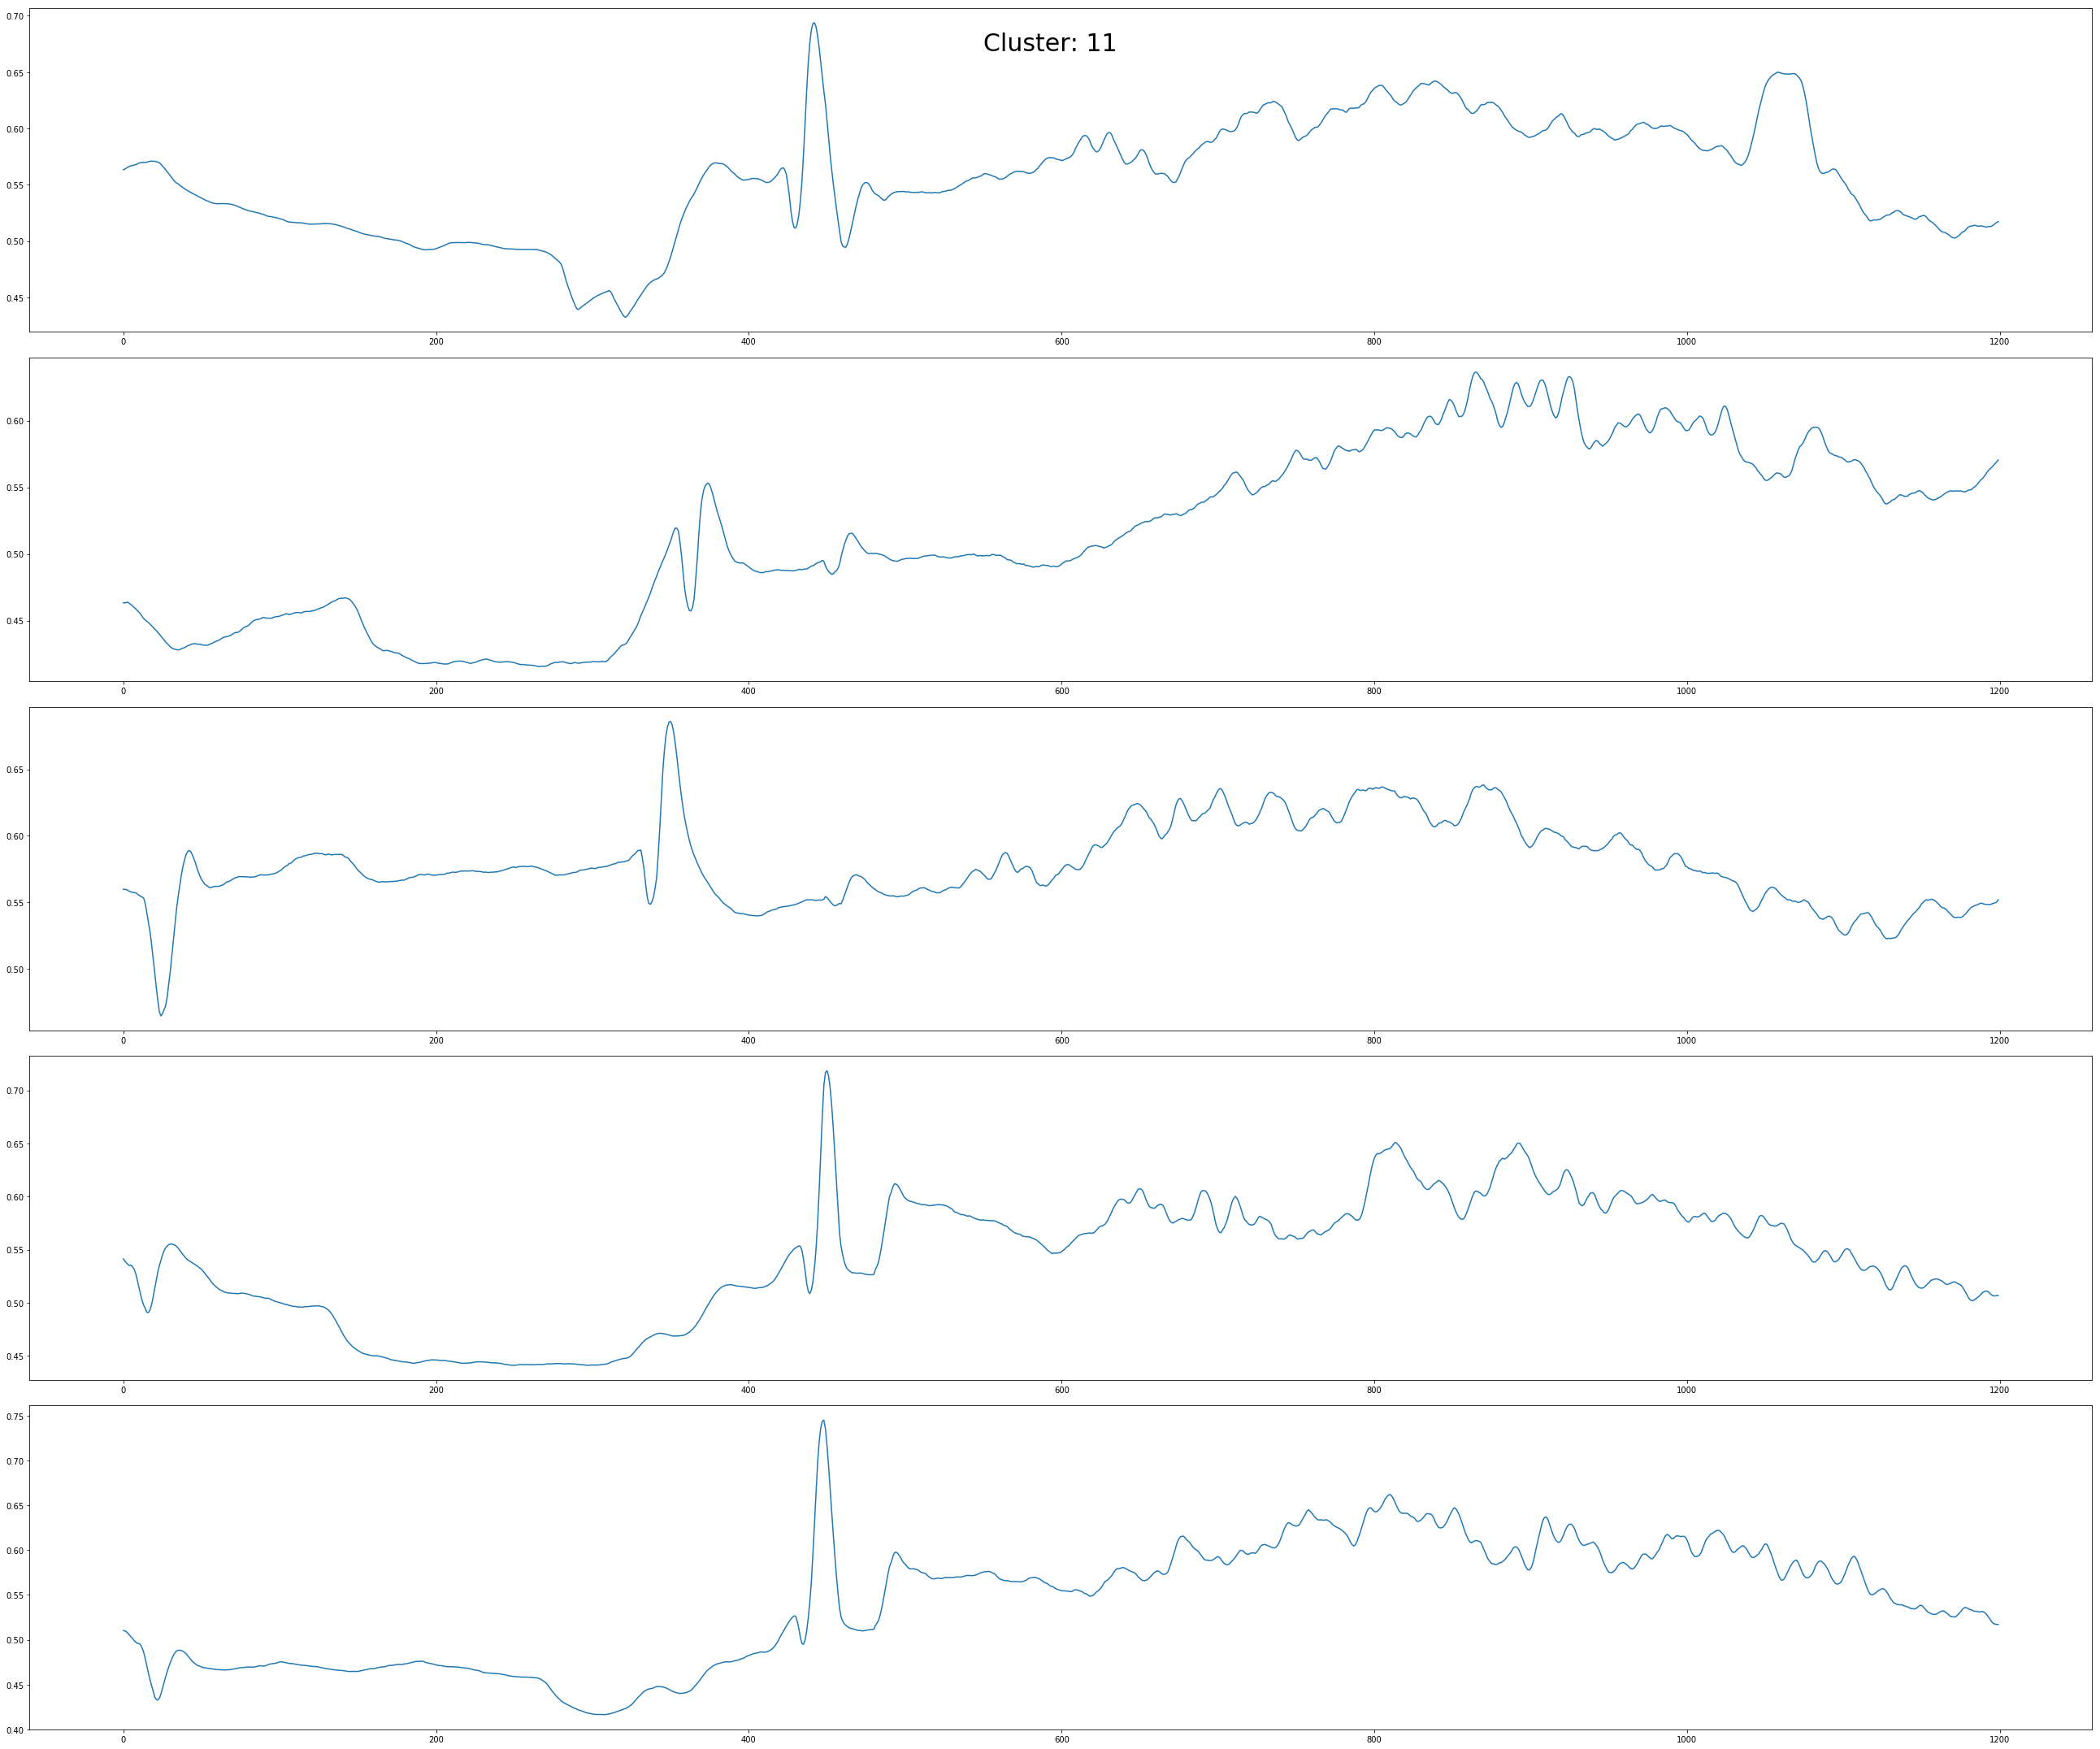

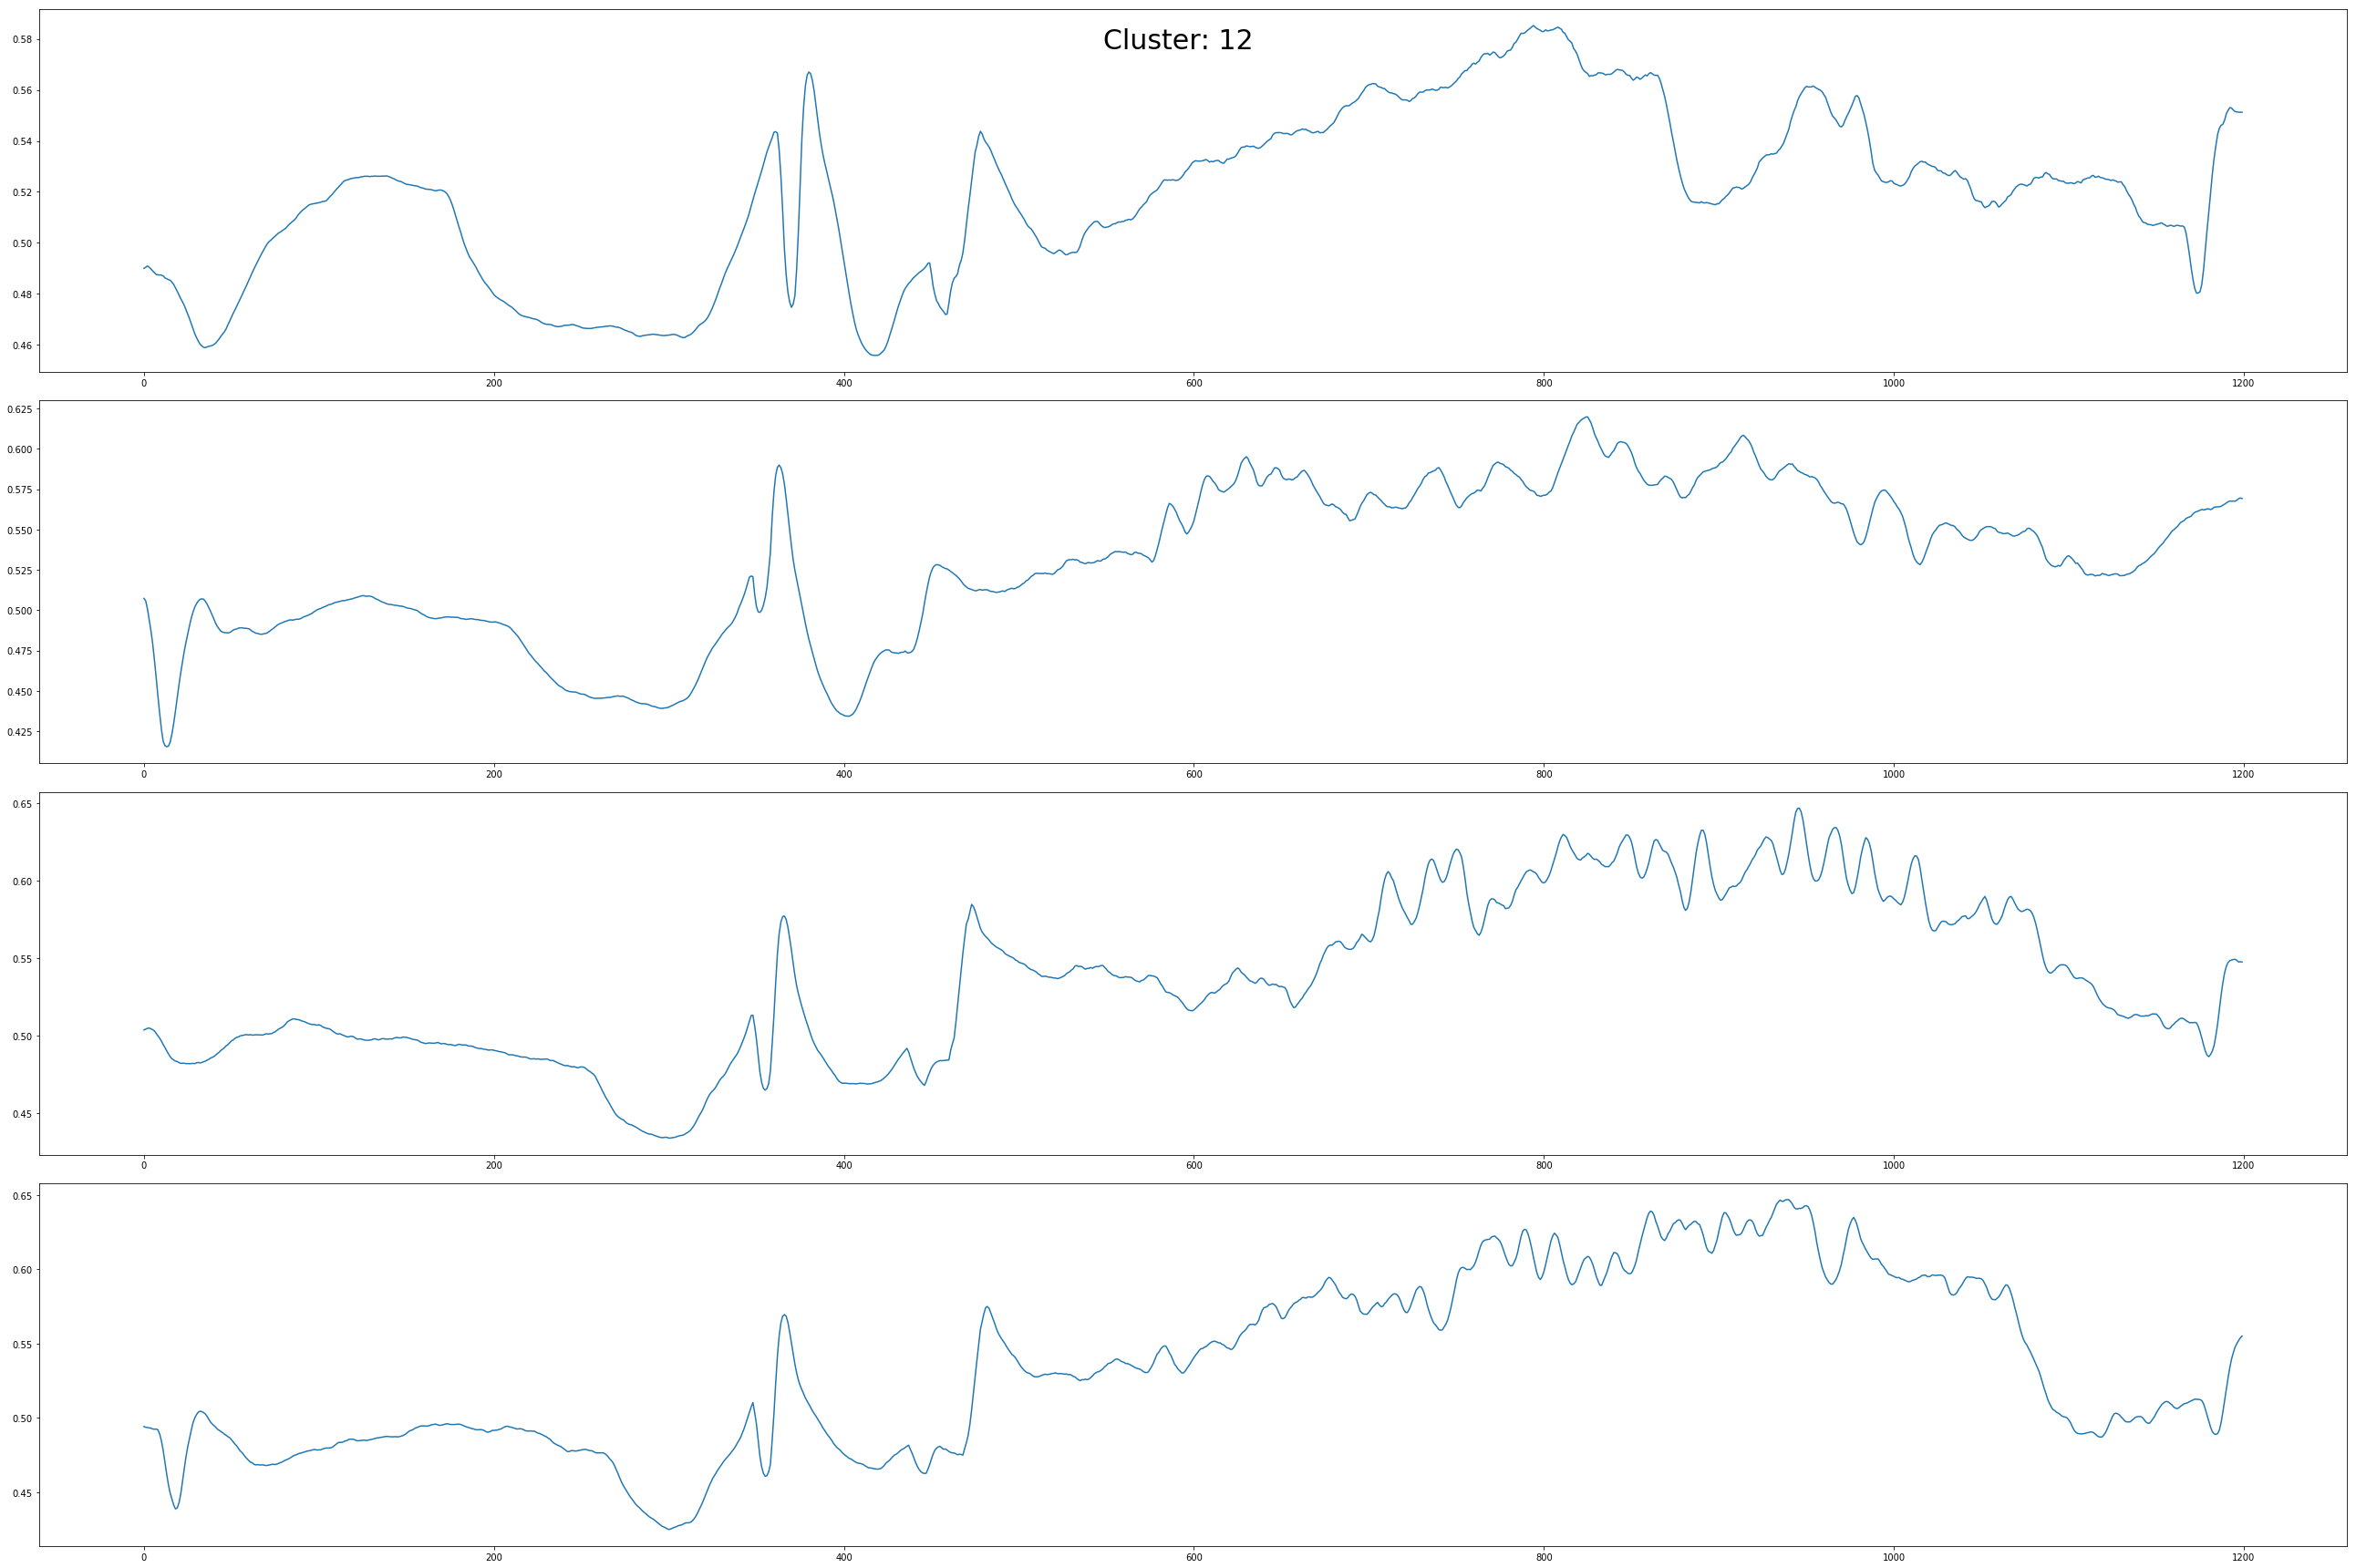

In [10]:
# Look at chunks of a cluster.. 
cluster_ids = [11, 12]


for i in cluster_ids:
    chunk_ids = grouped_chunks[i]
    cnt = chunk_ids.shape[0]
    fig, ax = plt.subplots(cnt, 1, figsize=(36, 6*cnt))
    fig.suptitle("Cluster: {}".format(i), fontsize=30)
    for idx, j in enumerate(chunk_ids):
        if len(chunk_ids) == 1: # matplotlib is such a shit.. 
            ax.plot(chunks[j])
        else:
            ax[idx].plot(chunks[j])
    fig.tight_layout()

## Pairwise values of 100 chunks..

In [11]:
from scipy.spatial.distance import pdist, squareform
pairwise_dtw = pickle_cache("../output/pairwise.pickle")(pdist)(chunks, distance_func)
pairwise_dtw_matrix = squareform(pairwise_dtw)

Loading from cache:  ../output/pairwise.pickle


In [12]:
pd.Series(pairwise_dtw).describe()

count    4095.000000
mean     50.510660  
std      37.661486  
min      6.207931   
25%      25.968858  
50%      38.085875  
75%      61.541540  
max      266.098309 
dtype: float64

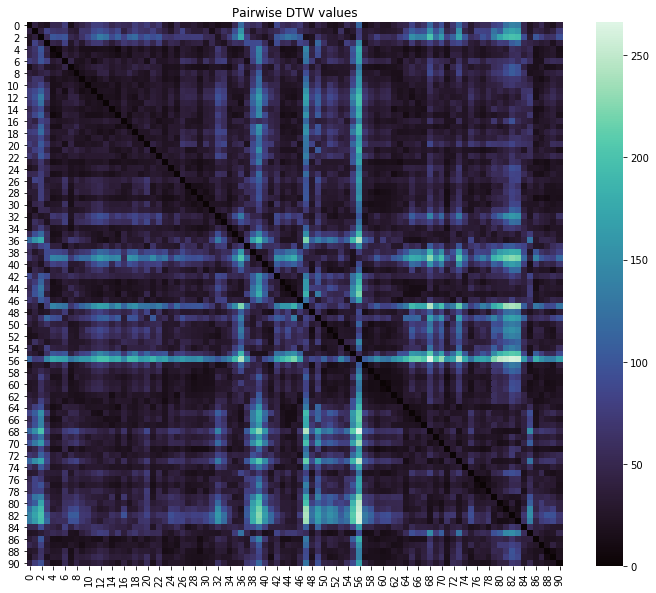

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
sns.heatmap(pairwise_dtw_matrix, cmap="mako")
ax.set_title("Pairwise DTW values")

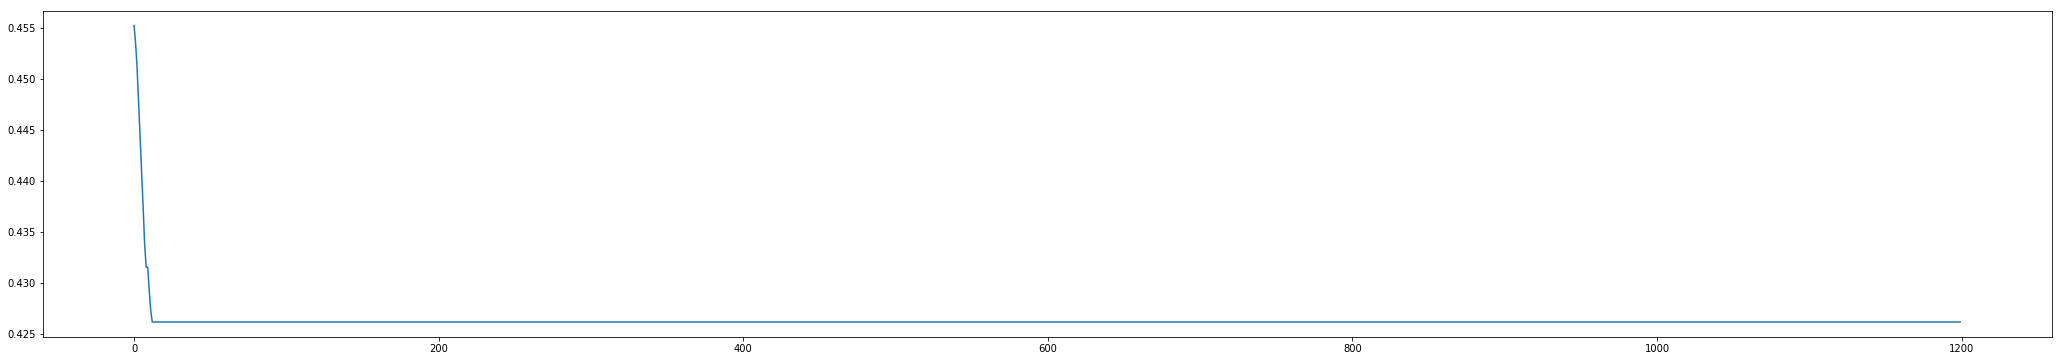

In [14]:
# anomalies; ID := 56 (look at these light color lines..)
fig, ax = plt.subplots(1,1, figsize=(36,6))
ax.plot(chunks[56])

## Pairwise values of the entire CWSHDR timeseries
Each chunk := 1 day, sampled at 1 hr

(1403, 1)


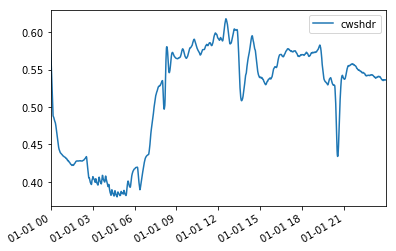

In [15]:
ts = df["2016-01-01":"2016-01-01"]
ts.plot()
print(ts.shape)

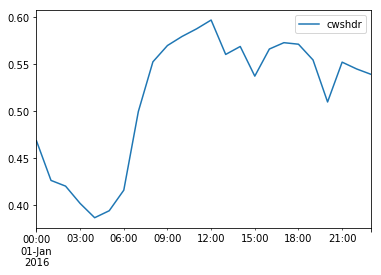

In [16]:
# downsampled.... 
ts.resample("1H").mean().plot()

In [17]:
df_downsampled = df.resample("1H").mean().fillna(method="pad")
df_downsampled.shape, df.shape

((28248, 1), (1673660, 1))

In [18]:
chunks, periods = create_chunks(df_downsampled, size=24)
chunks.shape, periods.shape

Total days:  1177


((1177, 24), (1177,))

In [19]:
pairwise_dtw = pickle_cache("../output/pairwise2.pickle")(pdist)(chunks, distance_func)
pairwise_dtw_matrix = squareform(pairwise_dtw)

Loading from cache:  ../output/pairwise2.pickle


In [20]:
pairwise_dtw = pd.Series(pairwise_dtw)
pairwise_dtw -= pairwise_dtw.min()
pairwise_dtw /= (pairwise_dtw.max() - pairwise_dtw.min())
pairwise_dtw.describe()

count    692076.000000
mean     0.189829     
std      0.121595     
min      0.000000     
25%      0.104912     
50%      0.153726     
75%      0.236305     
max      1.000000     
dtype: float64

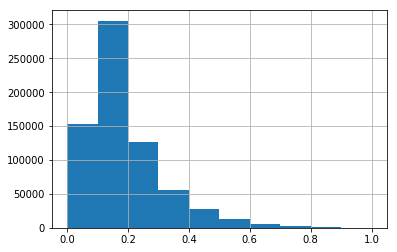

In [21]:
pairwise_dtw.hist()

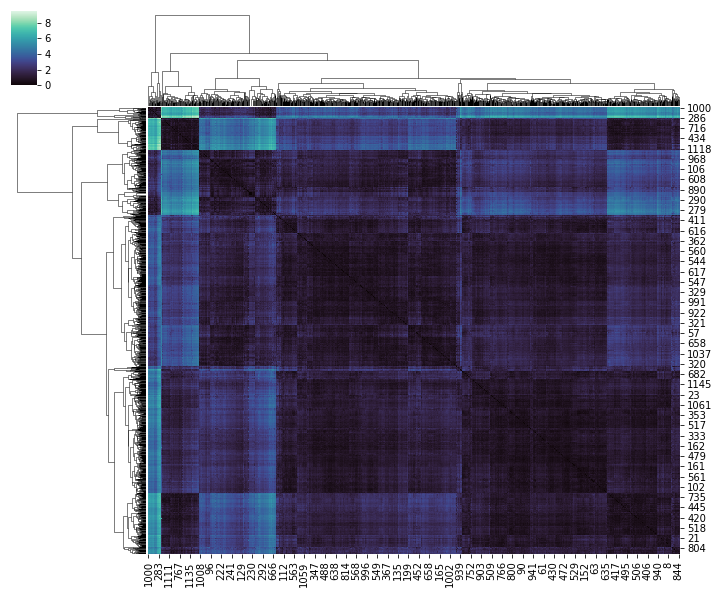

In [23]:
# agglomerative clustered pairs of timeseries chunks..
sns.clustermap(
    pairwise_dtw_matrix,
    cmap="mako",
    figsize=(12,10)
)

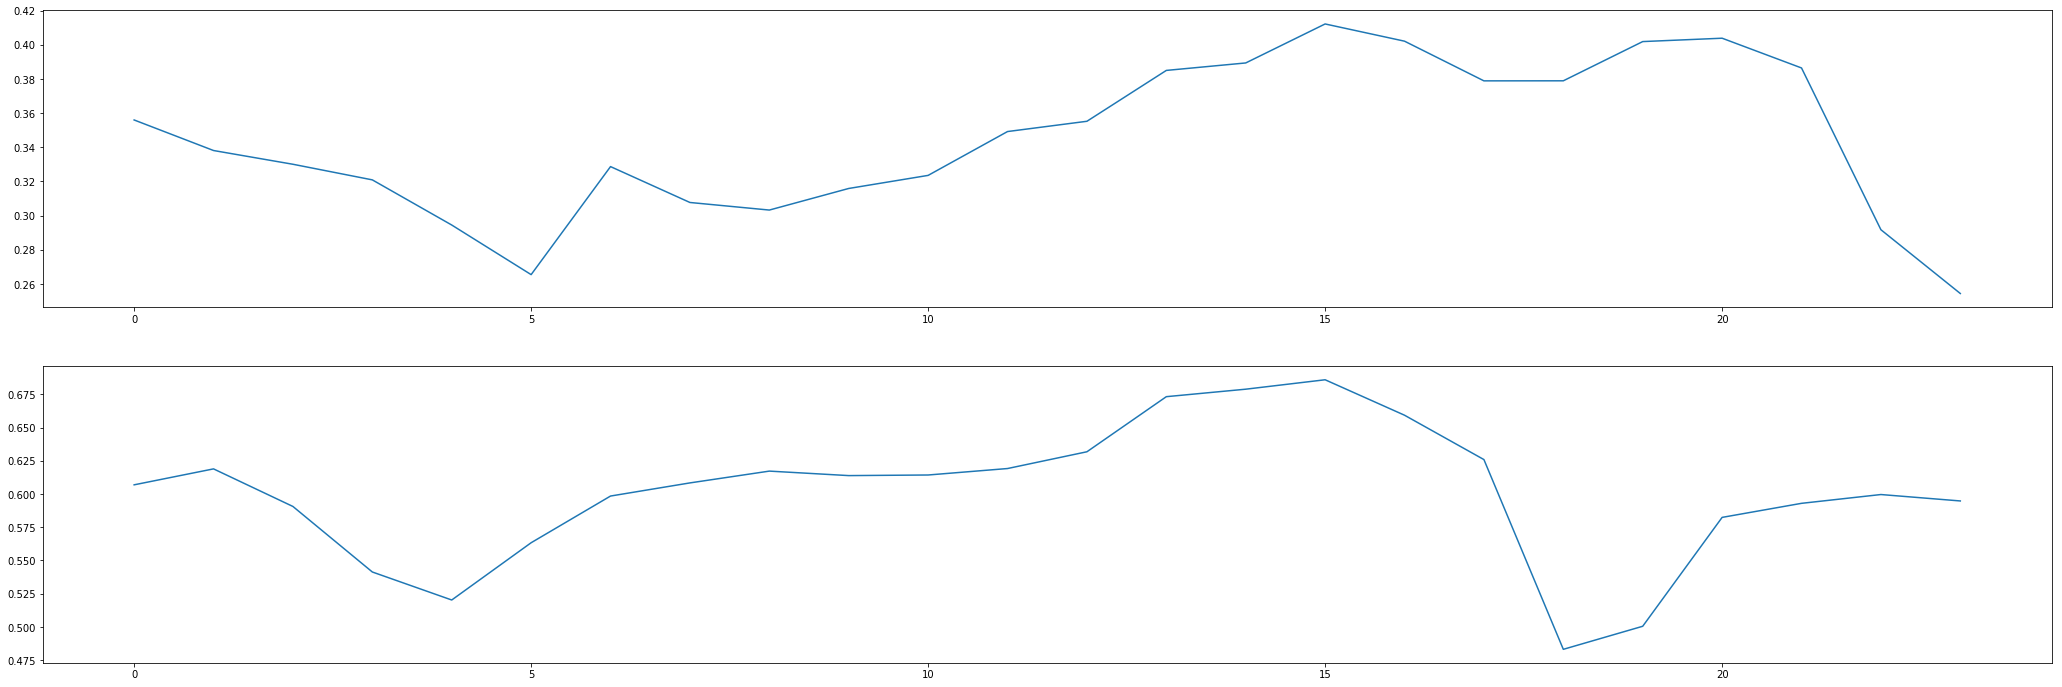

In [36]:
chunk_ids = [286, 518]
fig, ax = plt.subplots(len(chunk_ids),1,figsize=(36,6 * len(chunk_ids)))
if len(chunk_ids)==1:
    ax.plot(chunks[chunk_ids[-1]])
else:
    for i,c in enumerate(chunk_ids):
        ax[i].plot(chunks[c])